In [157]:
import cv2
import imutils
import math
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

## Strip Detection & Comparison

This script takes a raw picture of the strips, detects the sensible regions of the strips, and compares all the strips with the right-most which is asummed to be the water control.

This version uses an image with an artificial black background.

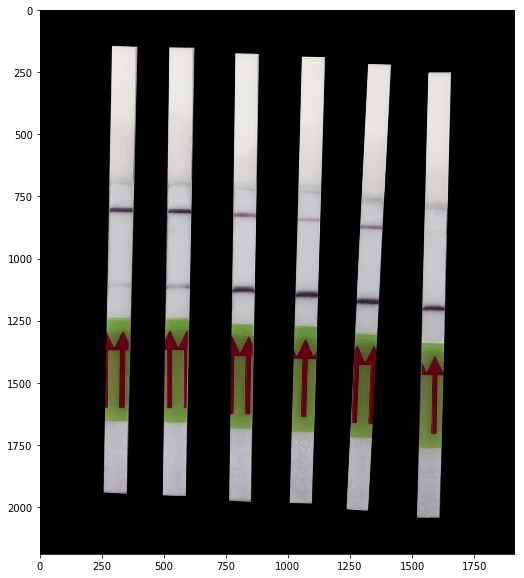

In [158]:
filename = 'images/strips12c.jpg'
image = cv2.imread(filename)
image = cv2.GaussianBlur(image, (5,5), 0)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [197]:
# Parameters - All of these should normalized as a function of the image resolution and 
# expected size of the strips

w = image.shape[0]
h = image.shape[1]

# The Y value above which the top of the strip should be 
maxTopY = int(w * 0.2)

# The Y value above which the begining of the sensitive part of the strip should be
maxCenterY = int(w * 0.65)

# Minimum area of the colored center box in the strip
maxCenterBoxArea = 10000

# Maximum area of the colored center box in the strip
maxCenterBoxArea = 50000

# Minimum area of the top strip boxes
minTopBoxArea = 40000

# Maximum of the top strip boxes
maxTopBoxArea = 70000

# Minimum intensity for binary thresholding of the top portion of the strips
minStripThreshold = 190

# Sensitive area of the strip
stripWidth = 200
stripHeight = 2000
stripHoldY = 850

# Percentage of the margins to be removed
marginFraction = 0.2

# Times the standard deviation of the mean intensity to detect a peak
peakSTDScale = 4

# Red is at the beginning/end of the hue range, so it covers the [0-10] and the [170, 180] (hue in OpenCV varies
# between 0 and 180 degrees)
lower_red1 = np.array([0, 50, 50]) 
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 50, 50]) 
upper_red2 = np.array([180, 255, 255])

# Green is between 20 and 90 (these ranges can be adjusted)
lower_green = np.array([20, 50, 50]) 
upper_green = np.array([90, 255, 255])

In [160]:
# Some utilities

def makeOrderedBox(rect):
    box0 = cv2.boxPoints(rect)
    box0 = np.int0(box0)
    
    xval = [pt[0] for pt in box0]
    yval = [pt[1] for pt in box0]
    
    x0 = np.mean(xval)
    y0 = np.mean(yval)
  
    angles = []
    for i in range(0, len(box0)):
        xi = box0[i][0]
        yi = box0[i][1]        
        x = xi - x0
        y = yi - y0
        a = np.arctan2(y, x)
        val = [a, i]
        angles += [val]

    angles.sort(key=lambda val: val[0], reverse=False)    
    box = np.array([box0[val[1]] for val in angles])
    
    return box

def boxMinX(box):
    return min([pt[0] for pt in box])

def boxMaxX(box):  
    return max([pt[0] for pt in box])

def boxMinY(box):
    return min([pt[1] for pt in box])

def boxMaxY(box):
    return max([pt[1] for pt in box])

def boxArea(box):
    x0 = np.mean([pt[0] for pt in box])
    y0 = np.mean([pt[1] for pt in box])
    p0 = np.array([x0, y0])
    
    area = 0
    n = len(box)
    for i in range(0, n):
        p1 = box[i]
        if i < n - 1:
            p2 = box[i + 1]
        else:
            p2 = box[0]
            
        # Heron's Formula
        a = np.linalg.norm(p1-p0)
        b = np.linalg.norm(p2-p0)
        c = np.linalg.norm(p1-p2)
        s = (a + b + c) / 2
        triarea = np.sqrt(s * (s - a) * (s - b) * (s - c))
        
        area += triarea        
        
    return area

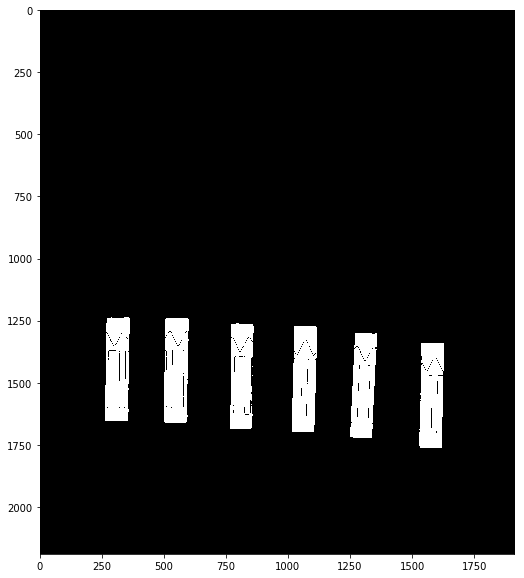

In [161]:
# Processing Step 1: detecting the colored area in the strips

# First, convert the image to HSV color space, which makes the color detection straightforward
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# These strips have red arrows on a green background, so we define two masks, one for red and the other for green

red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1) 
red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2) 

red_mask = red_mask1 + red_mask2
green_mask = cv2.inRange(hsv, lower_green, upper_green)

mask = red_mask + green_mask

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

Found suitable center box
39503.500000000015
[[1534 1337]
 [1627 1339]
 [1617 1764]
 [1524 1761]]
Found suitable center box
38418.99999999996
[[1267 1296]
 [1357 1301]
 [1337 1724]
 [1246 1720]]
Found suitable center box
39409.00000000009
[[1023 1269]
 [1115 1272]
 [1104 1700]
 [1012 1697]]
Found suitable center box
37863.999999999956
[[ 770 1261]
 [ 859 1262]
 [ 854 1685]
 [ 764 1684]]
Found suitable center box
40403.000000000015
[[ 504 1237]
 [ 599 1238]
 [ 593 1661]
 [ 497 1660]]
Found suitable center box
40240.00000000003
[[ 267 1235]
 [ 363 1237]
 [ 355 1656]
 [ 259 1654]]


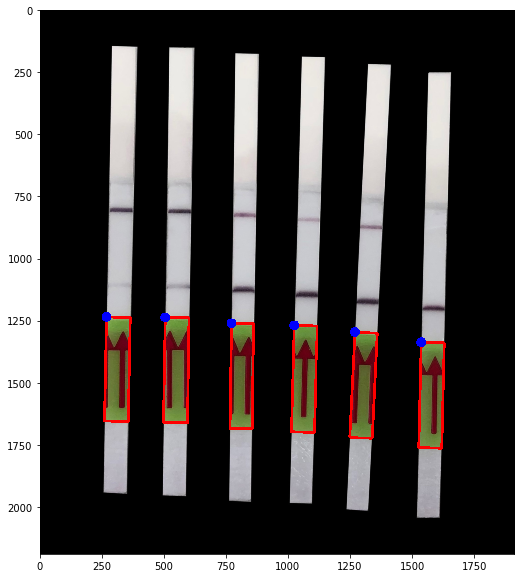

In [162]:
# Processing Step 2: determining the bounding boxes for the colored areas
    
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

center_boxes = []
for c in cnts:
    M = cv2.moments(c)
    if M["m00"] == 0: continue
            
    rect = cv2.minAreaRect(c)
    box = makeOrderedBox(rect)
    
    area = boxArea(box)
    if area < minCenterBoxArea or maxCenterBoxArea < area: continue
    
    if maxCenterY < boxMinY(box): continue

    print("Found suitable center box")
    print(area)    
    print(box)
    center_boxes += [box]
     
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 20, (255,0,0), -1)
    
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

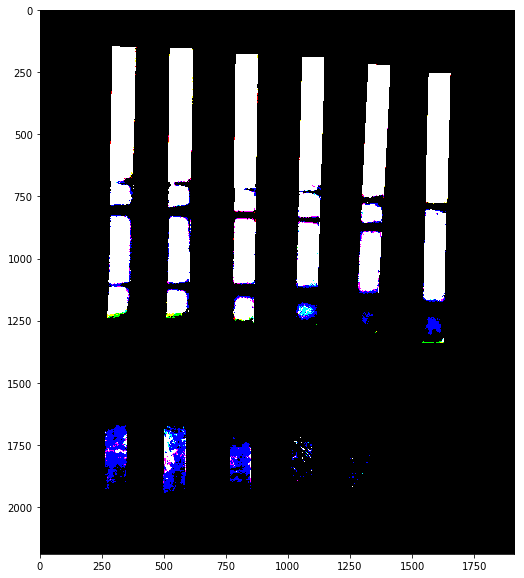

In [163]:
# Processing Step 3: binary thresholding of the entire image to extract the top part of the strips
ret, thresh = cv2.threshold(image, minStripThreshold, 255, cv2.THRESH_BINARY)

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

Found suitable top box
47155.50000000014
[[1563  250]
 [1653  253]
 [1639  779]
 [1550  777]]
Found suitable top box
47865.500000000095
[[1321  216]
 [1410  221]
 [1384  757]
 [1295  753]]
Found suitable top box
59056.00000000007
[[1054  188]
 [1145  190]
 [1128  839]
 [1037  836]]
Found suitable top box
58385.499999999825
[[786 175]
 [877 176]
 [869 814]
 [777 813]]
Found suitable top box
60917.99999999975
[[521 151]
 [615 152]
 [607 797]
 [512 795]]
Found suitable top box
63265.999999999956
[[289 145]
 [388 147]
 [373 789]
 [275 787]]


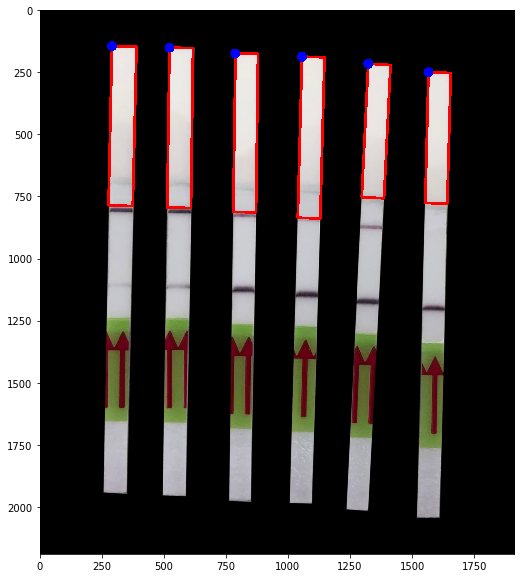

In [164]:
# Processing Step 4: detect boundary boxes for the top of the strips

grayscale = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
cnts = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

top_boxes = []
for c in cnts:
    M = cv2.moments(c)
    if M["m00"] == 0: continue
            
    rect = cv2.minAreaRect(c)
    box = makeOrderedBox(rect)
    
    area = boxArea(box)
    if area < minTopBoxArea or maxTopBoxArea < area: continue
        
    if maxTopY < boxMinY(box): continue

    print("Found suitable top box")
    print(area)    
    print(box)
    top_boxes += [box]
    
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    tmp = cv2.circle(tmp, (box[0][0], box[0][1]), 20, (255,0,0), -1)
    
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [165]:
# From:
# https://www.cs.hmc.edu/ACM/lectures/intersections.html
    
def intersectLines(pt1, pt2, ptA, ptB): 
    """ this returns the intersection of Line(pt1,pt2) and Line(ptA,ptB)
        
        returns a tuple: (xi, yi, valid, r, s), where
        (xi, yi) is the intersection
        r is the scalar multiple such that (xi,yi) = pt1 + r*(pt2-pt1)
        s is the scalar multiple such that (xi,yi) = pt1 + s*(ptB-ptA)
            valid == 0 if there are 0 or inf. intersections (invalid)
            valid == 1 if it has a unique intersection ON the segment    """

    DET_TOLERANCE = 0.00000001

    # the first line is pt1 + r*(pt2-pt1)
    # in component form:
    x1, y1 = pt1;   x2, y2 = pt2
    dx1 = x2 - x1;  dy1 = y2 - y1

    # the second line is ptA + s*(ptB-ptA)
    x, y = ptA;   xB, yB = ptB;
    dx = xB - x;  dy = yB - y;

    # we need to find the (typically unique) values of r and s
    # that will satisfy
    #
    # (x1, y1) + r(dx1, dy1) = (x, y) + s(dx, dy)
    #
    # which is the same as
    #
    #    [ dx1  -dx ][ r ] = [ x-x1 ]
    #    [ dy1  -dy ][ s ] = [ y-y1 ]
    #
    # whose solution is
    #
    #    [ r ] = _1_  [  -dy   dx ] [ x-x1 ]
    #    [ s ] = DET  [ -dy1  dx1 ] [ y-y1 ]
    #
    # where DET = (-dx1 * dy + dy1 * dx)
    #
    # if DET is too small, they're parallel
    #
    DET = (-dx1 * dy + dy1 * dx)

    if math.fabs(DET) < DET_TOLERANCE: return (0,0,0,0,0)

    # now, the determinant should be OK
    DETinv = 1.0/DET

    # find the scalar amount along the "self" segment
    r = DETinv * (-dy  * (x-x1) +  dx * (y-y1))

    # find the scalar amount along the input line
    s = DETinv * (-dy1 * (x-x1) + dx1 * (y-y1))

    # return the average of the two descriptions
    xi = (x1 + r*dx1 + x + s*dx)/2.0
    yi = (y1 + r*dy1 + y + s*dy)/2.0
    return ( xi, yi, 1, r, s )

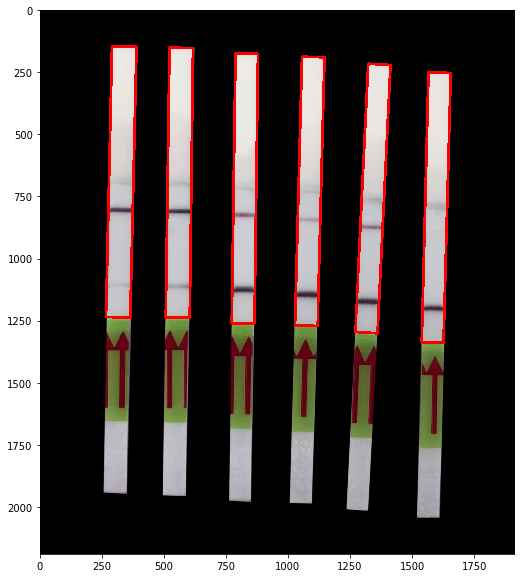

In [166]:
# Processing Step 5: construct the boxes that enclose the sensitive strip area

# First, order the top and center boxes from left to right
top_boxes.sort(key=lambda box: box[0][0], reverse=False)
center_boxes.sort(key=lambda box: box[0][0], reverse=False)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

assert(len(top_boxes) == len(center_boxes)), "Different number of top and center boxes"

num_boxes = len(top_boxes)

strip_boxes = []

for i in range(0, num_boxes):
    tbox = top_boxes[i]
    cbox = center_boxes[i]    

    # The corners are expected to be received in the following order:
    # 0 = botton left corner
    # 1 = top left corner   
    # 2 = top right corner 
    # 3 = bottom right corner
        
    tp0, tp1, tp2, tp3 = tbox[3], tbox[0], tbox[1], tbox[2]
    cp0, cp1, cp2, cp3 = cbox[3], cbox[0], cbox[1], cbox[2]
    
    # The intersection of the lines defining the sides of the strip (tp1-tp0 and tp2-tp3)
    # with the top edge of the center box defines the bottom corners of the area of interest
    res1 = intersectLines(tp1, tp0, cp1, cp2)
    res2 = intersectLines(tp2, tp3, cp1, cp2) 
    
    assert(res1[2] == 1 and res2[2] == 1), "Top and center boxes are not intersecting"
    
    p1 = np.array([int(round(res1[0])), int(round(res1[1]))])
    p2 = np.array([int(round(res2[0])), int(round(res2[1]))])
    
    sbox = np.array([p1, tp1, tp2, p2])
#     sbox = np.array([cp1, tp1, tp2, cp2])
    
    strip_boxes += [sbox]
    tmp = cv2.drawContours(tmp, [sbox], 0, (0, 0, 255), 10)
        
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [192]:
# Processing Step 6: Extract the strips into separate images

ref_box = np.array([[0, 0],[0, stripHeight],[stripWidth, stripHeight],[stripWidth, 0]], dtype=float)

raw_strip_images = []
for sbx in strip_boxes:
    h, status = cv2.findHomography(sbx, ref_box)
    img = cv2.warpPerspective(image, h, (stripWidth, stripHeight))
    raw_strip_images += [img]

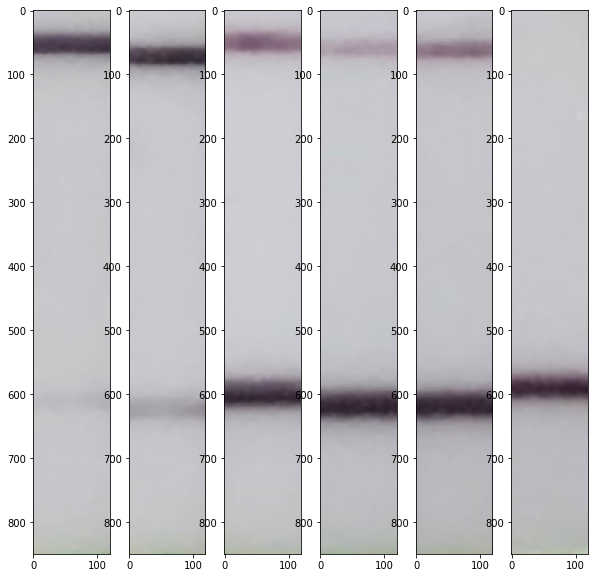

In [193]:
# Processing Step 7: Crop the images to remove the grip of the strips, and the vertical borders

norm_strip_images = []

fig, plots = plt.subplots(1, len(raw_strip_images))
idx = 0
for img in raw_strip_images:
    # Crop out the top and the bottom parts of the strip, and applying bilateral filtering for smoothing
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    x0 = int(marginFraction * stripWidth)
    x1 = int((1 - marginFraction) * stripWidth)
    y0 = 0
    y1 = stripHoldY

    crop = img[y0:y1, x0:x1]
    nimg = cv2.bilateralFilter(crop, 9, 75, 75)
    norm_strip_images += [nimg]
    
    vimg = cv2.flip(nimg, 0)
    plots[idx].imshow(cv2.cvtColor(vimg, cv2.COLOR_BGR2RGB))
    idx += 1

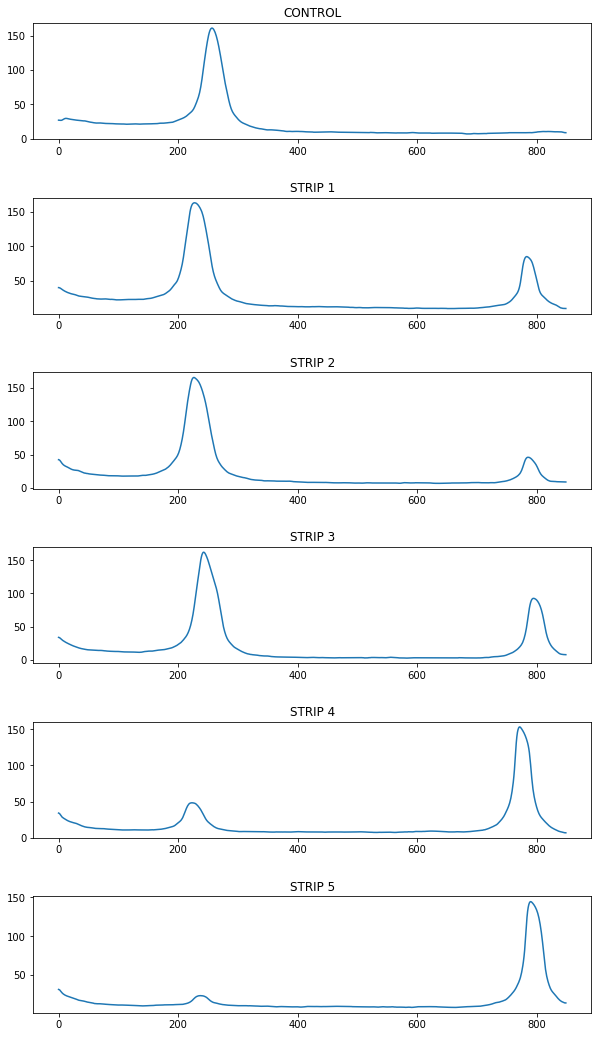

In [206]:
# Processing Step 8: Plot all intensities

fig, plots = plt.subplots(len(norm_strip_images))
plt.subplots_adjust(top=1.5, hspace=0.5)
idx = len(norm_strip_images) - 1
for img in norm_strip_images:
    data = img.astype('int32') 
    nrows = data.shape[0]
    values = np.array([])
    for r in range(0, nrows):
        values = np.append(values, 210 - np.mean(data[r]))    
    plots[idx].plot(values)
    if idx == 0:
        plots[idx].set_title("CONTROL")
    else:
        plots[idx].set_title("STRIP " + str(idx))
    idx -= 1

No peak found in control
Found peak in test 4 at 365 with a value of 65.47777777777777
  Normalized peak value: 135.58333333333334
Found peak in test 3 at 347 with a value of 56.605555555555554
  Normalized peak value: 144.41944444444445
Found peak in test 2 at 370 with a value of 117.525
  Normalized peak value: 83.33055555555555
Found peak in test 1 at 361 with a value of 164.0
  Normalized peak value: 36.897222222222226
Found peak in test 0 at 359 with a value of 124.70833333333333
  Normalized peak value: 76.34722222222223


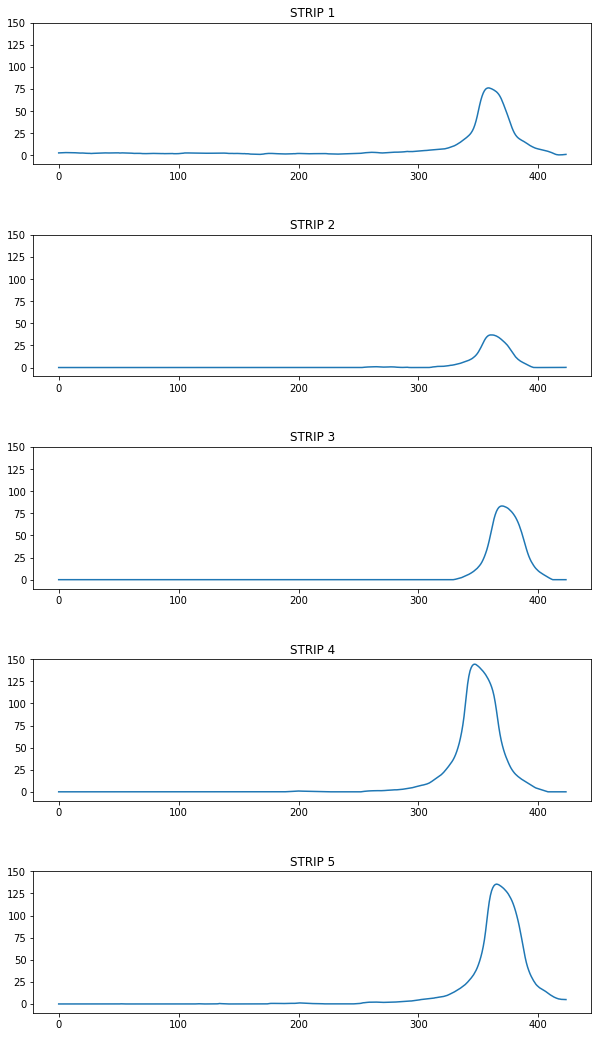

In [210]:
# Processing Step 9: Compare all test images with the control image (last)

def getPeak(data, start):
    nrows = data.shape[0]
    values = np.array([])
    for r in range(0, nrows):    
        values = np.append(values, np.mean(data[r]))
    
    v = values[start:-1]
    mean = np.mean(v[0:int(len(v)/2)])
    std = np.std(v[0:int(len(v)/2)])
    
    i = np.argmin(v)    
    peak = np.min(v)
    if peak < mean - peakSTDScale * std:
        return i, peak, v     
    else:
        return None, None, v

ctrl_img = norm_strip_images[-1]

# Convert from uint8 to int32 so we can get negative values
ctrl_data = ctrl_img.astype('int32')
half = int(ctrl_data.shape[0]/2)
ctrl_pk_idx, ctrl_pk_val, ctrl_all_val = getPeak(ctrl_data, half)
if ctrl_pk_idx:
    print("Found peak in control at", ctrl_pk_idx, "with a value of", ctrl_pk_val)
else:
    print("No peak found in control")
    
fig, plots = plt.subplots(len(norm_strip_images) - 1)
plt.subplots_adjust(top=1.5, hspace=0.5)

idx = len(norm_strip_images) - 2
for test_img in norm_strip_images[0:-1]:
    test_data = test_img.astype('int32')        
    test_pk_idx, test_pk_val, test_all_val = getPeak(test_data, half)
    
    if test_pk_idx:
        print("Found peak in test", idx, "at", test_pk_idx, "with a value of", test_pk_val)
    else:
        print("No peak found in test", idx)
        
    if test_pk_idx and ctrl_pk_idx and test_pk_idx != ctrl_pk_idx:
        idx_diff = test_pk_idx - ctrl_pk_idx
        print("Need to align peaks by", idx_diff)

        # Very inefficient way of doing this... 
        rows = []
        for i in range(half, ctrl_data.shape[0]):
            if i + idx_diff < test_data.shape[0]:
                d = test_data[i + idx_diff] - ctrl_data[i]
                rows.append(d)
                
        diff = np.array(rows)
    else:
        # No alignment is needed
        diff = test_data - ctrl_data
        diff = diff[half:-1]
        
    # Another possibility could be to use OpenCV's image integrals:
    # http://www.aishack.in/tutorials/integral-images-opencv/

    values = np.array([]) 
    nrows = diff.shape[0]    
    for r in range(0, nrows):
        m = -min(0, np.mean(diff[r]))
        values = np.append(values, m)
        
    normPeak = max(values)    
    print("  Normalized peak value:", normPeak)

    plots[idx].set_ylim([-10, 150])
    plots[idx].set_title("STRIP " + str(idx + 1))
    plots[idx].plot(values)
    idx -= 1